In [1]:
# %matplotlib inline
%matplotlib widget
%load_ext autoreload
%autoreload 2
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import os
import sys
sys.path.insert(0, 'functions/')
from h5_tools import *
from fitting_tools import *
from tools import *
# from h5_tools import *
import numpy as np
import h5py as h5
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter
# import pandas as pd

# plot general settings
mpl.rcParams.update({"axes.grid" : True, "grid.color": "gray", "grid.linestyle":":", "grid.alpha": "0.5", "font.size": 14})
plt.rcParams['legend.title_fontsize'] = 'small'

import scipy as sp
import scipy.interpolate

In [3]:
h5dir = '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/'

In [4]:
def gaussian_off(x, a, mean, sigma, c):
    """ Gaussian """
    return a * np.exp( -((x-mean)/sigma)**2 ) + c

# Load files

In [5]:
# bkg 0003 "vacuum"
f = np.load("../03-source/bkg_background_0003.npz")
print(f.files)
# Iq_bkg = np.average(f['Iq'][:2,:], axis=0)
Iq_bkg = np.where(f['Iq']==0, np.nan, f['Iq'])
q_bkg = f['q']
t_exp_bkg = 1e-1

# water/glycerol
f = np.load("../03-source/bkg_water_gly_50_2_0002.npz")
print(f.files)
# Iq_bkg = np.average(f['Iq'][:2,:], axis=0)
Iq_bkg_w = f['Iq'][2,:]
Iq_bkg_w = np.where(f['Iq'][2,:]==0, np.nan, f['Iq'][2,:])
q_bkg_w = f['q']
# q_bkg_w = q_bkg_w[f['Iq'][2,:] != 0]
t_exp_bkg_w = 1e-1

# apoferritin
# f = np.load("../03-source/Iqs_apo_conc_gly_50_2_0006.npz")
# f.files
# Iq_apo = np.average(f['Iqs'],axis=0)
# q_apo = f['q']
# t_exp_apo = 5e-3

# apoferritin short exp time
f = np.load("../03-source/bkg_apo_conc_gly_50_2_0002.npz")
f.files
Iq_apo = f['Iq']
Iq_apo = np.where(f['Iq']==0, np.nan, f['Iq'])
q_apo = f['q']
t_exp_apo = 0.0002

['Iq', 'q']
['Iq', 'q']


In [6]:
f = np.load('../03-source/id02/Iqs.npz')
# f.files
Iqs_id02 = f['Iqs']
q_id02 = f['q']
c_id02 = f['concs']
print(np.shape(Iqs_id02), np.shape(q_id02))

(5, 1500) (1500,)


# Temperatures

In [7]:
# c1 temps 250-210 K full beam
runnames = ['ferritin_conc_gly_50_6']
datasetnumbers = [2,3,4,5,6]

if len(runnames) == 1:
    runnames = runnames*len(datasetnumbers)
runnames


['ferritin_conc_gly_50_6',
 'ferritin_conc_gly_50_6',
 'ferritin_conc_gly_50_6',
 'ferritin_conc_gly_50_6',
 'ferritin_conc_gly_50_6']

In [8]:
T, Tr = [], []

for i,(datasetnumber, runname) in enumerate(zip(datasetnumbers, runnames)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'

    if os.path.isfile(filename):
        print(filename, "\nFile exists: ", os.path.isfile(filename), "\n")
        info = elog_selected_entries_dict(filename)
        for key in info.keys():
            print("{0:20} {1}".format(key, info[key]))
        Tr.append(info['transmission (%)'])
        T.append(info['Temperature, K'])
    else:
        print(filename, "\nFile exists: False")

/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_6_0002.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_6_0002
Temperature, K       250.0
transmission (%)     100
Absorbers 80um       0.0
Absorbers 100um      0.0
Short comment        nan
comment              xpcs, 4 reps per spot, 250K, full beam
Exposure time (s)    0.0002
number of frames     5000.0
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_6_0003.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_6_0003
Temperature, K       240.0
transmission (%)     100
Absorbers 80um       0.0
Absorbers 100um      0.0
Short comment        nan
comment              xpcs, 4 reps per spot, 240K, full beam
Exposure time (s)    0.0002
number of frames     5000.0
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_6_0004.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_6_0004
Temp

In [9]:
filename = h5dir + f'{runname}_{datasetnumbers[0]:04d}.h5'
rep = 0
qI = load_data(filename, '/saxs/q') # 1000

Iqs = np.empty(shape=(len(datasetnumbers),len(qI)))
t_exp = []

for i,(datasetnumber) in enumerate(datasetnumbers):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'
    Iqs[i,:] = load_data(filename, '/saxs/I_reps_filtered')[rep,:] # (4, 1000)
    info = elog_selected_entries_dict(filename)
    t_exp.append(load_data(filename, 'xpcs/g2s/delay')[0])
    print(datasetnumber, f'{t_exp[i]:.4f}', 's')

print(np.shape(Iqs), np.shape(qI))

2 0.0002 s
3 0.0002 s
4 0.0002 s
5 0.0002 s
6 0.0002 s
(5, 1000) (1000,)


(0.0, 1.5)

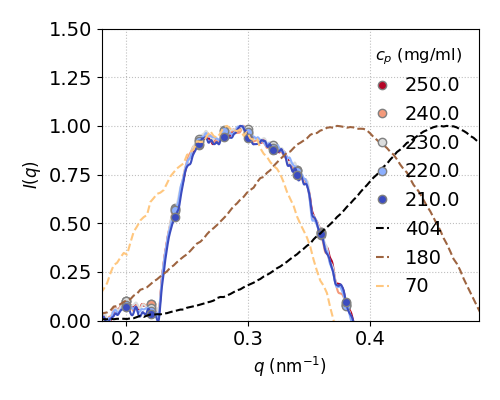

In [10]:
f, a1 = plt.subplots(1,1, figsize=(5,4), tight_layout=True)
# -- left id10
col = plt.cm.coolwarm_r(np.linspace(0,1,len(datasetnumbers)))
q_new = np.linspace(0.068, 0.468, 20)

Iq_interp, q_interp = [], []

# c_id10 = ['c1', 'c2', 'c3']
for i in range(len(datasetnumbers)):
    y = Iqs[i,:]/t_exp[i]
    y_smooth = gaussian_filter(y, sigma=2)
    qi_min, qistep, qi_max = 320, 30, -20
    b = np.mean(y_smooth[qi_min:qi_min+qistep])
    b = y_smooth[qi_min]
    A = np.nanmax(y_smooth[qi_min:qi_max]-b)
    if i==0:
        q_new = np.linspace(0.068, 0.37, 20)
        q_new = np.arange(0.2, 0.4, 0.02)
    else:
        q_new = np.linspace(0.2, 0.468, 20)
        q_new = np.arange(0.2, 0.5, 0.02)
    # a1.plot(qI, y, ls='--',  c=col[i]) 
    a1.plot(qI, (y_smooth-b)/A, ls='-',  c=col[i]) 

    # interpolate
    y_interp =  sp.interpolate.interp1d(qI, (y_smooth-b)/A, kind='linear')
    a1.plot(q_new, y_interp(q_new), marker='o', mec='gray', c=col[i], ls='',  label=T[i])#label=c_id10[i])
    q_interp.append(q_new)
    Iq_interp.append(y_interp(q_new))


# -- id02
cols = plt.cm.copper(np.linspace(0,1,len(Iqs_id02)-2))
for j in range(len(Iqs_id02)-2):
    qi_min, qistep, qi_max = 43, 10, 155
    b2 = Iqs_id02[j,qi_min]
    A2 = np.nanmax(Iqs_id02[j,qi_min:qi_max]-b2)

    a1.plot(q_id02, (Iqs_id02[j,:]-b2)/A2, label=c_id02[j], c=cols[j], ls='--')

# -- plot settings
a1.legend(title='$c_p$ (mg/ml)', handlelength=.7, frameon=False, ncol=1)
a1.set_xlabel(r'$q$ (nm$^{-1}$)', fontsize=12)
a1.set_ylabel('$I(q)$', fontsize=12)
a1.set_xlim(.18,qI[-1])
a1.set_ylim(0, 1.5)


### Subtract bkg

(0.0, 2.0)

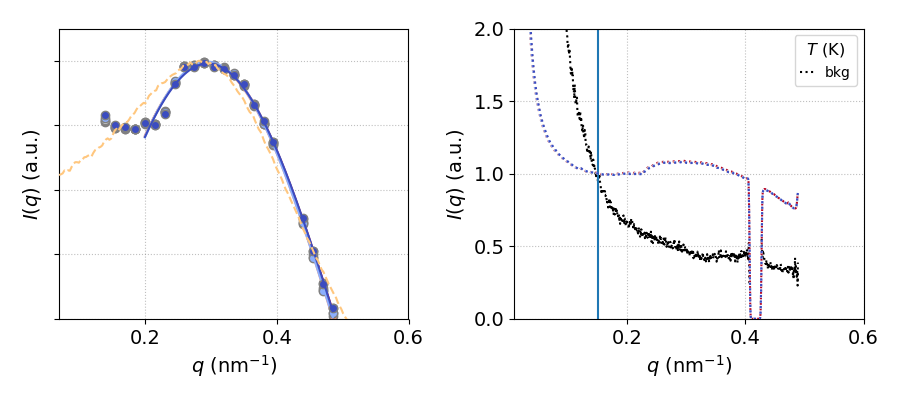

In [84]:
f, (a1,a2) = plt.subplots(1,2, figsize=(9,4), tight_layout=True)

# -- left id10
col = plt.cm.coolwarm_r(np.linspace(0,1,len(datasetnumbers)))
# q_new = np.linspace(0.068, 0.468, 20)

# -- id02
cols = plt.cm.copper(np.linspace(0,1,len(Iqs_id02)-2))
# for j in range(len(Iqs_id02)-2):
j = 2
qi_min, qistep, qi_max = 43, 10, 155
b2 = Iqs_id02[j,qi_min]
A2 = np.nanmax(Iqs_id02[j,qi_min:qi_max]-b2)
a1.plot(q_id02, (Iqs_id02[j,:]-b2)/A2, label='300 | ID02', c=cols[j], ls='--', zorder=10)



# -- bkg
# Iq_bkg_w q_bkg_w
qi_bkg = 300
I = Iq_bkg_w / t_exp_bkg_w
bbg = I[qi_min]
Abg = 1 # np.nanmax(Iq_bkg_w[qi_min:qi_max]-bbg)
a2.plot(q_bkg_w, (I ) / I[qi_bkg], label='bkg', c='k', ls=':')
# a2.plot(q_bkg_w, (I - bbg) / Abg, label='bkg', c='k', ls=':')
Iq_bk_new =  (I - bbg) / Abg
# a2.plot(q_bkg_w, Iq_bkg_w, label='bkg', c='k', ls=':')

a2.axvline(x=qI[qi_bkg])


# -- id10 here
Iq_interp, q_interp = [], []
q_max = []

qi_min, qistep, qi_max = 380, 30, -20

for i in range(len(datasetnumbers)):
    y = Iqs[i,:]/t_exp[i]
    y_smooth = gaussian_filter(y, sigma=2)
    
    # b = np.mean(y_smooth[qi_min:qi_min+qistep])
    b = y_smooth[qi_min]
    A = np.nanmax(y_smooth[qi_min:qi_max]-b)
    # a2.plot(qI, (y-b)/A,  c=col[i], ls='-' )

    off = 0
    q_new = np.concatenate([np.arange(0.14, 0.4, 0.015), np.arange(0.44, 0.488, 0.015)])

    # interpolate
    # a1.plot(qI, (y_smooth-b)/A, mec='gray', c=col[i], ls='-')

    y_interp =  sp.interpolate.interp1d(qI, (y_smooth-b)/A, kind='linear')
    a1.plot(q_new, y_interp(q_new)-off, marker='o', mec='gray', c=col[i], ls='',)
    q_interp.append(q_new)
    Iq_interp.append(y_interp(q_new))
    
    xmin, xmax = 4, -1
    bounds_min = [0, 0, 0.1, -100]
    bounds_max = [1000, 1, 1, 100]

    popt,xc,curve,perr = fit(gaussian_off, q_new[xmin:], y_interp(q_new)[xmin:], p0=[1., 0.3, 1., 1.], bounds=(bounds_min, bounds_max))
    # q_max.append(popt[1])
    a1.plot(xc, curve, c=col[i], label=f'{float(T[i]):.0f}')


    # # bkg subtr
    y_smooth = gaussian_filter(y, sigma=2)
    y_smooth_n = y_smooth / y_smooth[qi_bkg]
    a2.plot(qI, y_smooth_n,  c=col[i], ls=':' )
    a2.plot(qI, y_smooth_n - I,  c=col[i], ls='-' )

    # # b = np.mean(y_smooth[qi_min:qi_min+qistep])
    # b = y_smooth[qi_min]
    # A = np.nanmax(y_smooth[qi_min:qi_max]-b)
    # # a2.plot(qI, (y-b)/A,  c=col[i], ls='-' )

    # off = 0
    # q_new = np.concatenate([np.arange(0.14, 0.4, 0.015), np.arange(0.44, 0.488, 0.015)])

    # # interpolate
    # # a1.plot(qI, (y_smooth-b)/A, mec='gray', c=col[i], ls='-')

    # y_interp =  sp.interpolate.interp1d(qI, (y_smooth-b)/A, kind='linear')
    # a1.plot(q_new, y_interp(q_new)-off, marker='o', mec='gray', c=col[i], ls='',)
    # q_interp.append(q_new)
    # Iq_interp.append(y_interp(q_new))
    
    # xmin, xmax = 4, -1
    # bounds_min = [0, 0, 0.1, -100]
    # bounds_max = [1000, 1, 1, 100]

    # popt,xc,curve,perr = fit(gaussian_off, q_new[xmin:], y_interp(q_new)[xmin:], p0=[1., 0.3, 1., 1.], bounds=(bounds_min, bounds_max))
    # # q_max.append(popt[1])
    # a1.plot(xc, curve, c=col[i], label=f'{float(T[i]):.0f}')



# -- plot settings
# a1.legend(title='$T$ (K)', handlelength=1, ncol=1,  fontsize=10,)
a1.set_xlabel(r'$q$ (nm$^{-1}$)')
a1.set_ylabel('$I(q)$ (a.u.)')
a1.set_yticklabels([])
a1.set_xlim(0.07,0.6)
a1.set_ylim(-3,1.5)


a2.legend(title='$T$ (K)', handlelength=1, ncol=1,  fontsize=10,)
a2.set_xlabel(r'$q$ (nm$^{-1}$)')
a2.set_ylabel('$I(q)$ (a.u.)')
a2.set_xlim(0.01,0.6)
# a2.set_yscale('log')
a2.set_ylim(0,2)
# plt.savefig('../06-figs/Iq-temps.png', dpi=300)

### Final plot

(-3.0, 1.5)

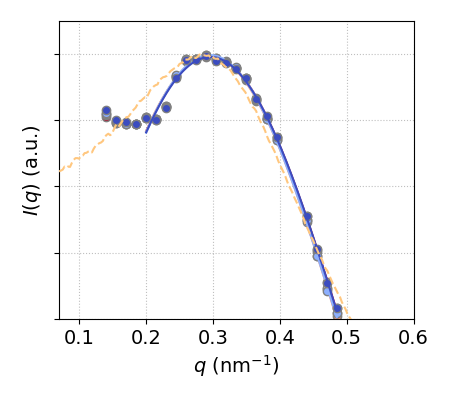

In [59]:
f, a1 = plt.subplots(1,1, figsize=(4.5,4), tight_layout=True)

# -- left id10
col = plt.cm.coolwarm_r(np.linspace(0,1,len(datasetnumbers)))
# q_new = np.linspace(0.068, 0.468, 20)

# -- id02
cols = plt.cm.copper(np.linspace(0,1,len(Iqs_id02)-2))
# for j in range(len(Iqs_id02)-2):
j = 2
qi_min, qistep, qi_max = 43, 10, 155
b2 = Iqs_id02[j,qi_min]
A2 = np.nanmax(Iqs_id02[j,qi_min:qi_max]-b2)

a1.plot(q_id02, (Iqs_id02[j,:]-b2)/A2, label='300 | ID02', c=cols[j], ls='--', zorder=10)

# -- id10 here
Iq_interp, q_interp = [], []
q_max = []

qi_min, qistep, qi_max = 380, 30, -20

for i in range(len(datasetnumbers)):
    y = Iqs[i,:]/t_exp[i]
    y_smooth = gaussian_filter(y, sigma=2)
    
    # b = np.mean(y_smooth[qi_min:qi_min+qistep])
    b = y_smooth[qi_min]
    A = np.nanmax(y_smooth[qi_min:qi_max]-b)
    # a2.plot(qI, (y-b)/A,  c=col[i], ls='-' )

    off = 0
    q_new = np.concatenate([np.arange(0.14, 0.4, 0.015), np.arange(0.44, 0.488, 0.015)])

    # interpolate
    # a1.plot(qI, (y_smooth-b)/A, mec='gray', c=col[i], ls='-')

    y_interp =  sp.interpolate.interp1d(qI, (y_smooth-b)/A, kind='linear')
    a1.plot(q_new, y_interp(q_new)-off, marker='o', mec='gray', c=col[i], ls='',)
    q_interp.append(q_new)
    Iq_interp.append(y_interp(q_new))
    
    
    xmin, xmax = 4, -1
    bounds_min = [0, 0, 0.1, -100]
    bounds_max = [1000, 1, 1, 100]

    popt,xc,curve,perr = fit(gaussian_off, q_new[xmin:], y_interp(q_new)[xmin:], p0=[1., 0.3, 1., 1.], bounds=(bounds_min, bounds_max))
    # q_max.append(popt[1])
    a1.plot(xc, curve, c=col[i], label=f'{float(T[i]):.0f}')
    

# -- plot settings
# a1.legend(title='$T$ (K)', handlelength=1, ncol=1,  fontsize=10,)
a1.set_xlabel(r'$q$ (nm$^{-1}$)')
a1.set_ylabel('$I(q)$ (a.u.)')
a1.set_yticklabels([])
a1.set_xlim(0.07,0.6)
a1.set_ylim(-3,1.5)

# plt.savefig('../06-figs/Iq-temps.png', dpi=300)

# Fluxes

In [ ]:
# c1 temps 250-210 K full beam
# c1 50-75 mg/ml before adding gly 220K
runname = ['ferritin_conc_gly_50_5']
datasetnumbers = [4,5,6]

if len(runname) == 1:
    runnames = runname*len(datasetnumbers)
runnames


['ferritin_conc_gly_50_5', 'ferritin_conc_gly_50_5', 'ferritin_conc_gly_50_5']

In [ ]:
T, Tr = [], []

for i,(datasetnumber, runname) in enumerate(zip(datasetnumbers, runnames)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'

    if os.path.isfile(filename):
        print(filename, "\nFile exists: ", os.path.isfile(filename), "\n")
        info = elog_selected_entries_dict(filename)
        for key in info.keys():
            print("{0:20} {1}".format(key, info[key]))
        Tr.append(info['transmission (%)'])
        T.append(info['Temperature, K'])
    else:
        print(filename, "\nFile exists: False")

/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_5_0004.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_5_0004
Temperature, K       220.0
transmission (%)     100
Absorbers 80um       0.0
Absorbers 100um      0.0
Short comment        nan
comment              xpcs, 4 reps per spot, 220K, full beam
Exposure time (s)    0.0002
number of frames     5000.0
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_5_0005.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_5_0005
Temperature, K       220.0
transmission (%)     45
Absorbers 80um       1.0
Absorbers 100um      0.0
Short comment        nan
comment              xpcs, 4 reps per spot, 220K, 45% beam
Exposure time (s)    0.0004
number of frames     5000.0
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_5_0006.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_5_0006
Temper

In [ ]:
filename = h5dir + f'{runname}_{datasetnumbers[0]:04d}.h5'
rep = 0
qI = load_data(filename, '/saxs/q') # 1000

Iqs = np.empty(shape=(len(datasetnumbers),len(qI)))
t_exp = []

for i,(datasetnumber) in enumerate(datasetnumbers):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'
    Iqs[i,:] = load_data(filename, '/saxs/I_reps_filtered')[rep,:] # (4, 1000)
    info = elog_selected_entries_dict(filename)
    t_exp.append(load_data(filename, 'xpcs/g2s/delay')[0])
    print(datasetnumber, f'{t_exp[i]:.4f}', 's')

print(np.shape(Iqs), np.shape(qI))

4 0.0002 s
5 0.0004 s
6 0.0004 s
(3, 1000) (1000,)


(0.0, 1.5)

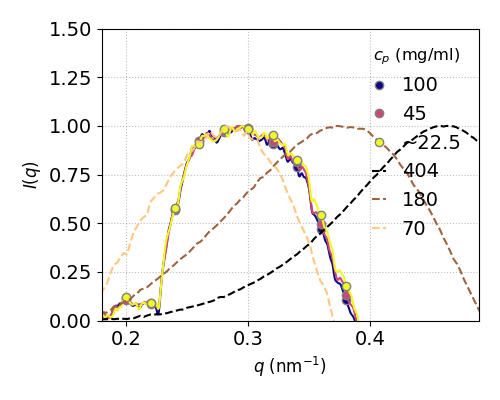

In [ ]:
f, a1 = plt.subplots(1,1, figsize=(5,4), tight_layout=True)
# -- left id10
col = plt.cm.plasma(np.linspace(0,1,len(datasetnumbers)))
q_new = np.linspace(0.068, 0.468, 20)

Iq_interp, q_interp = [], []

# c_id10 = ['c1', 'c2', 'c3']
for i in range(len(datasetnumbers)):
    y = Iqs[i,:]/t_exp[i]
    y_smooth = gaussian_filter(y, sigma=2)
    qi_min, qistep, qi_max = 320, 30, -20
    b = np.mean(y_smooth[qi_min:qi_min+qistep])
    b = y_smooth[qi_min]
    A = np.nanmax(y_smooth[qi_min:qi_max]-b)
    if i==0:
        q_new = np.linspace(0.068, 0.37, 20)
        q_new = np.arange(0.2, 0.4, 0.02)
    else:
        q_new = np.linspace(0.2, 0.468, 20)
        q_new = np.arange(0.2, 0.5, 0.02)
    # a1.plot(qI, y, ls='--',  c=col[i]) 
    a1.plot(qI, (y_smooth-b)/A, ls='-',  c=col[i]) 

    # interpolate
    y_interp =  sp.interpolate.interp1d(qI, (y_smooth-b)/A, kind='linear')
    a1.plot(q_new, y_interp(q_new), marker='o', mec='gray', c=col[i], ls='',  label=Tr[i])#label=c_id10[i])
    q_interp.append(q_new)
    Iq_interp.append(y_interp(q_new))


# -- id02
cols = plt.cm.copper(np.linspace(0,1,len(Iqs_id02)-2))
for j in range(len(Iqs_id02)-2):
    qi_min, qistep, qi_max = 43, 10, 155
    b2 = Iqs_id02[j,qi_min]
    A2 = np.nanmax(Iqs_id02[j,qi_min:qi_max]-b2)

    a1.plot(q_id02, (Iqs_id02[j,:]-b2)/A2, label=c_id02[j], c=cols[j], ls='--')

# -- plot settings
a1.legend(title='$c_p$ (mg/ml)', handlelength=.7, frameon=False, ncol=1)
a1.set_xlabel(r'$q$ (nm$^{-1}$)', fontsize=12)
a1.set_ylabel('$I(q)$', fontsize=12)
a1.set_xlim(.18,qI[-1])
a1.set_ylim(0, 1.5)


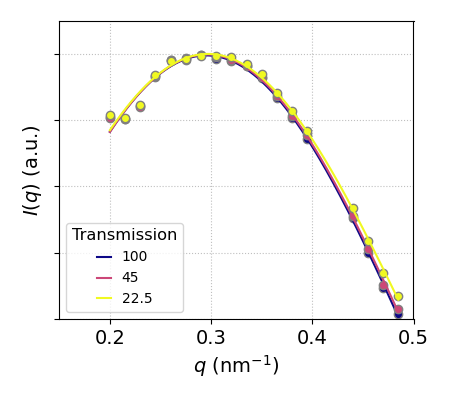

In [ ]:
f, a1 = plt.subplots(1,1, figsize=(4.5,4), tight_layout=True)

# -- left id10
col = plt.cm.plasma(np.linspace(0,1,len(datasetnumbers)))
q_new = np.linspace(0.068, 0.468, 20)

Iq_interp, q_interp = [], []
q_max = []

qi_min, qistep, qi_max = 380, 30, -20

for i in range(len(datasetnumbers)):
    y = Iqs[i,:]/t_exp[i]
    y_smooth = gaussian_filter(y, sigma=2)
    
    # b = np.mean(y_smooth[qi_min:qi_min+qistep])
    b = y_smooth[qi_min]
    A = np.nanmax(y_smooth[qi_min:qi_max]-b)
    a2.plot(qI, (y-b)/A,  c=col[i], ls='-' )

    off = 0
    q_new = np.concatenate([np.arange(0.2, 0.4, 0.015), np.arange(0.44, 0.488, 0.015)])


    # interpolate
    # a1.plot(qI, (y_smooth-b)/A, mec='gray', c=col[i], ls='-')

    y_interp =  sp.interpolate.interp1d(qI, (y_smooth-b)/A, kind='linear')
    a1.plot(q_new, y_interp(q_new)-off, marker='o', mec='gray', c=col[i], ls='',)
    q_interp.append(q_new)
    Iq_interp.append(y_interp(q_new))
    
    xmin, xmax = 0, -1
    bounds_min = [0, 0, 0.1, -100]
    bounds_max = [1000, 1, 1, 100]

    popt,xc,curve,perr = fit(gaussian_off, q_new[xmin:], y_interp(q_new)[xmin:], p0=[1., 0.3, 1., 1.], bounds=(bounds_min, bounds_max))
    # q_max.append(popt[1])
    if i == 2:
        a1.plot(xc, curve, c=col[i], label=Tr[i][1:])
    else: 
        a1.plot(xc, curve, c=col[i], label=Tr[i])


# -- plot settings
a1.legend(title='Transmission', handlelength=1, ncol=1,  fontsize=10,)
a1.set_xlabel(r'$q$ (nm$^{-1}$)')
a1.set_ylabel('$I(q)$ (a.u.)')
a1.set_yticklabels([])
a1.set_xlim(0.15,0.5)
a1.set_ylim(-3,1.5)

a2.set_xlim(0.1,qI[-1])
# a2.set_yscale('log')
a2.set_ylim(0,2)

# plt.savefig('../06-figs/Iq-fluxes.png', dpi=300)

# Repetitions

In [ ]:
runname = 'ferritin_conc_gly_50_5'
datasetnumber = 4


In [ ]:
filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'

if os.path.isfile(filename):
    print(filename, "\nFile exists: ", os.path.isfile(filename), "\n")
    info = elog_selected_entries_dict(filename)
    for key in info.keys():
        print("{0:20} {1}".format(key, info[key]))
    Tr = info['transmission (%)']
    T = info['Temperature, K']
else:
    print(filename, "\nFile exists: False")

/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_5_0004.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_5_0004
Temperature, K       220.0
transmission (%)     100
Absorbers 80um       0.0
Absorbers 100um      0.0
Short comment        nan
comment              xpcs, 4 reps per spot, 220K, full beam
Exposure time (s)    0.0002
number of frames     5000.0


In [ ]:
filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'
Iqs = load_data(filename, '/saxs/I_reps_filtered')[:,:] # (4, 1000)
info = elog_selected_entries_dict(filename)
t_exp = load_data(filename, 'xpcs/g2s/delay')[0]

In [ ]:
np.shape(Iqs)

(4, 1000)

(0.0, 1.5)

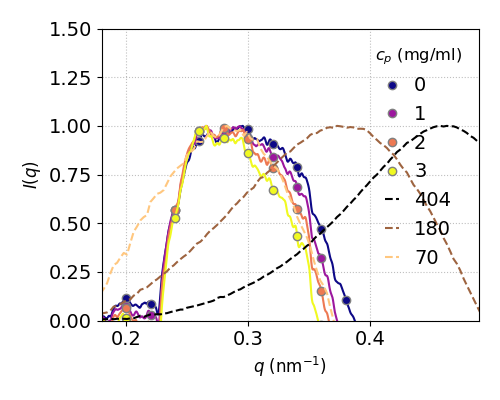

In [ ]:
f, a1 = plt.subplots(1,1, figsize=(5,4), tight_layout=True)
# -- left id10
col = plt.cm.plasma(np.linspace(0,1,4))
q_new = np.linspace(0.068, 0.468, 20)

Iq_interp, q_interp = [], []

for i in range(4):

    y = Iqs[i,:]/t_exp
    y_smooth = gaussian_filter(y, sigma=2)
    qi_min, qistep, qi_max = 320, 30, -20
    b = np.mean(y_smooth[qi_min:qi_min+qistep])
    b = y_smooth[qi_min]
    A = np.nanmax(y_smooth[qi_min:qi_max]-b)
    if i==0:
        q_new = np.linspace(0.068, 0.37, 20)
        q_new = np.arange(0.2, 0.4, 0.02)
    else:
        q_new = np.linspace(0.2, 0.468, 20)
        q_new = np.arange(0.2, 0.5, 0.02)
    # a1.plot(qI, y, ls='--',  c=col[i]) 
    a1.plot(qI, (y_smooth-b)/A, ls='-',  c=col[i]) 

    # interpolate
    y_interp =  sp.interpolate.interp1d(qI, (y_smooth-b)/A, kind='linear')
    a1.plot(q_new, y_interp(q_new), marker='o', mec='gray', c=col[i], ls='',  label=i)#label=c_id10[i])
    q_interp.append(q_new)
    Iq_interp.append(y_interp(q_new))


# -- id02
cols = plt.cm.copper(np.linspace(0,1,len(Iqs_id02)-2))
for j in range(len(Iqs_id02)-2):
    qi_min, qistep, qi_max = 43, 10, 155
    b2 = Iqs_id02[j,qi_min]
    A2 = np.nanmax(Iqs_id02[j,qi_min:qi_max]-b2)

    a1.plot(q_id02, (Iqs_id02[j,:]-b2)/A2, label=c_id02[j], c=cols[j], ls='--')

# -- plot settings
a1.legend(title='$c_p$ (mg/ml)', handlelength=.7, frameon=False, ncol=1)
a1.set_xlabel(r'$q$ (nm$^{-1}$)', fontsize=12)
a1.set_ylabel('$I(q)$', fontsize=12)
a1.set_xlim(.18,qI[-1])
a1.set_ylim(0, 1.5)


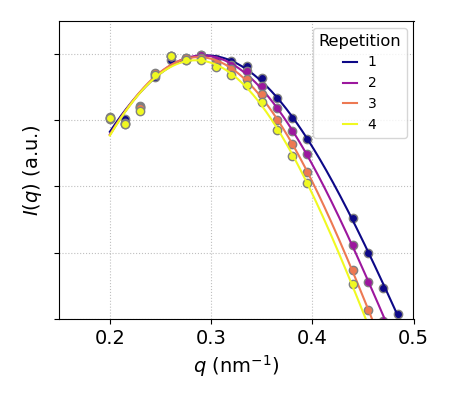

In [ ]:
f, a1 = plt.subplots(1,1, figsize=(4.5,4), tight_layout=True)
reps = 4
# -- left id10
col = plt.cm.plasma(np.linspace(0,1,reps))
q_new = np.linspace(0.068, 0.468, 20)

Iq_interp, q_interp = [], []
q_max = []

qi_min, qistep, qi_max = 380, 30, -20

for i in range(reps):
    y = Iqs[i,:]/t_exp
    y_smooth = gaussian_filter(y, sigma=2)
    
    # b = np.mean(y_smooth[qi_min:qi_min+qistep])
    b = y_smooth[qi_min]
    A = np.nanmax(y_smooth[qi_min:qi_max]-b)
    a2.plot(qI, (y-b)/A,  c=col[i], ls='-' )

    off = 0
    q_new = np.concatenate([np.arange(0.2, 0.4, 0.015), np.arange(0.44, 0.488, 0.015)])


    # interpolate
    # a1.plot(qI, (y_smooth-b)/A, mec='gray', c=col[i], ls='-')

    y_interp =  sp.interpolate.interp1d(qI, (y_smooth-b)/A, kind='linear')
    a1.plot(q_new, y_interp(q_new)-off, marker='o', mec='gray', c=col[i], ls='',)
    q_interp.append(q_new)
    Iq_interp.append(y_interp(q_new))
    
    xmin, xmax = 0, -1
    bounds_min = [0, 0, 0.1, -100]
    bounds_max = [1000, 1, 1, 100]

    popt,xc,curve,perr = fit(gaussian_off, q_new[xmin:], y_interp(q_new)[xmin:], p0=[1., 0.3, 1., 1.], bounds=(bounds_min, bounds_max))
    # q_max.append(popt[1])
    
    a1.plot(xc, curve, c=col[i], label=i+1)
    

# -- plot settings
a1.legend(title='Repetition', handlelength=1, ncol=1,  fontsize=10,)
a1.set_xlabel(r'$q$ (nm$^{-1}$)')
a1.set_ylabel('$I(q)$ (a.u.)')
a1.set_yticklabels([])
a1.set_xlim(0.15,0.5)  
a1.set_ylim(-3,1.5)

a2.set_xlim(0.1,qI[-1])
# a2.set_yscale('log')
a2.set_ylim(0,2)

# plt.savefig('../06-figs/Iq-reps.png', dpi=300)

# Concentrations

In [ ]:
# 240
runnames = ['ferritin_conc_gly_50_6', 'ferritin_conc100_gly_50_1', 'ferritin_conc120_gly_50_1']
datasetnumbers = [3,9,7] # 240 K

In [ ]:
T, Tr = [], []

for i,(datasetnumber, runname) in enumerate(zip(datasetnumbers, runnames)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'

    if os.path.isfile(filename):
        print(filename, "\nFile exists: ", os.path.isfile(filename), "\n")
        info = elog_selected_entries_dict(filename)
        for key in info.keys():
            print("{0:20} {1}".format(key, info[key]))
        Tr.append(info['transmission (%)'])
        T.append(info['Temperature, K'])
    else:
        print(filename, "\nFile exists: False")

In [ ]:
filename = h5dir + f'{runnames[0]}_{datasetnumbers[0]:04d}.h5'
rep = 0
qI = load_data(filename, '/saxs/q') # 1000

Iqs = np.empty(shape=(len(datasetnumbers),len(qI)))
t_exp = []

for i,(datasetnumber,runname) in enumerate(zip(datasetnumbers,runnames)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'
    Iq = load_data(filename, '/saxs/I_reps_filtered')[rep,:] # (4, 1000)
    # arr = np.where(arr==0, np.nan, arr)
    Iqs[i,:] = np.where(Iq==0, np.nan, Iq)

    info = elog_selected_entries_dict(filename)
    t_exp.append(delays[i,0])
    print(datasetnumber, f'{t_exp[i]:.4f}', 's')

print(np.shape(Iqs), np.shape(qI))

In [ ]:
f, (a1,a2) = plt.subplots(1,2, figsize=(9,4), tight_layout=True)
# -- left id10
col = plt.cm.copper_r(np.linspace(0,1,len(datasetnumbers)))
q_new = np.linspace(0.068, 0.468, 20)

Iq_interp, q_interp = [], []

c_id10 = ['c1', 'c2', 'c3']
for i in range(len(datasetnumbers)):
    y = Iqs[i,:]/t_exp[i]
    y_smooth = gaussian_filter(y, sigma=2)
    qi_min, qistep, qi_max = 320, 30, -20
    b = np.mean(y_smooth[qi_min:qi_min+qistep])
    b = y_smooth[qi_min]
    A = np.nanmax(y_smooth[qi_min:qi_max]-b)
    if i==0:
        q_new = np.linspace(0.068, 0.37, 20)
        q_new = np.arange(0.2, 0.4, 0.02)
    else:
        q_new = np.linspace(0.2, 0.468, 20)
        q_new = np.arange(0.2, 0.5, 0.02)
    # a1.plot(qI, y, ls='--',  c=col[i]) 
    a1.plot(qI, (y_smooth-b)/A, ls='-',  c=col[i]) 

    # interpolate
    y_interp =  sp.interpolate.interp1d(qI, (y_smooth-b)/A, kind='linear')
    a1.plot(q_new, y_interp(q_new), marker='o', mec='gray', c=col[i], ls='',  label=c_id10[i])
    q_interp.append(q_new)
    Iq_interp.append(y_interp(q_new))

a1.axvline(x=qI[qi_min], ls='--', c='gray', lw=1)
a1.axvline(x=qI[qi_min+qistep], ls='--', c='gray', lw=1)
a1.axvline(x=qI[qi_max], ls='--', c='gray', lw=1)
print(qI[qi_min], qI[qi_min+qistep], qI[qi_max])

# -- right id02
cols = plt.cm.copper(np.linspace(0,1,len(Iqs_id02)-2))

for j in range(len(Iqs_id02)-2):
    qi_min, qistep, qi_max = 43, 10, 155
    # b2 = np.mean(Iqs_id02[j,qi_min:qi_min+qistep])
    b2 = Iqs_id02[j,qi_min]
    A2 = np.nanmax(Iqs_id02[j,qi_min:qi_max]-b2)

    a1.plot(q_id02, (Iqs_id02[j,:]-b2)/A2, label=c_id02[j], c=cols[j], ls='--')
    a2.plot(q_id02, (Iqs_id02[j,:]-b2)/A2, label=c_id02[j], c=cols[j], ls='--')

print(q_id02[qi_min], q_id02[qi_min+qistep], q_id02[qi_max])

a2.axvline(x=q_id02[qi_min], ls='--', c='gray', lw=1)
a2.axvline(x=q_id02[qi_min+qistep], ls='--', c='gray', lw=1)
a2.axvline(x=q_id02[qi_max], ls='--', c='gray', lw=1)

# -- plot settings
a1.legend(title='$c_p$ (mg/ml)', handlelength=.7, frameon=False, ncol=1)
a1.set_xlabel(r'$q$ (nm$^{-1}$)', fontsize=12)
a1.set_ylabel('$I(q)$', fontsize=12)
a1.set_xlim(.18,qI[-1])
a1.set_ylim(0, 1.5)

a2.set_xlabel(r'$q$ (nm$^{-1}$)', fontsize=12)
a2.set_ylabel('I(q)', fontsize=12)
a2.set_xlim(.1,qI[-1])
a2.set_ylim(0,1.5)


In [ ]:
f, (a1,a2) = plt.subplots(1,2, figsize=(9,4), tight_layout=True)
# -- left id10
col = plt.cm.copper_r(np.linspace(0,1,len(datasetnumbers)))
q_new = np.linspace(0.068, 0.468, 20)

Iq_interp, q_interp = [], []

c_id10 = ['c1', 'c2', 'c3']
q_max = []

for i in range(len(datasetnumbers)):
    y = Iqs[i,:]/t_exp[i]
    y_smooth = gaussian_filter(y, sigma=2)
    qi_min, qistep, qi_max = 320, 30, -20
    b = np.mean(y_smooth[qi_min:qi_min+qistep])
    b = y_smooth[qi_min]
    A = np.nanmax(y_smooth[qi_min:qi_max]-b)
    
    off = -(i+2.5)
    # off = 0 

    if i==0:
        q_new = np.arange(0.2, 0.4, 0.015)
    else:
        q_new = np.array([0.2,  0.22, 0.24, 0.26, 0.28, 0.3,  0.32, 0.34, 0.36, 0.38, 0.4, 0.44, 0.46, 0.48])    

    # a1.plot(qI, y, ls='--',  c=col[i]) 
    # a1.plot(qI, (y_smooth-b)/A-i+2.5, ls='-',  c=col[i]) 

    # interpolate
    y_interp =  sp.interpolate.interp1d(qI, (y_smooth-b)/A, kind='linear')
    # a1.plot(q_new, y_interp(q_new)-i+2.5, marker='o', mec='gray', c=col[i], ls='',  label=c_id10[i])
    a1.plot(q_new, y_interp(q_new)-off, marker='o', mec='gray', c=col[i], ls='',  label=c_id10[i])
    q_interp.append(q_new)
    Iq_interp.append(y_interp(q_new))
    
    # # fit # a, mean, sigma, c
    xmin, xmax = i, -1
    if i == 2:
        xmin = 6
    
    bounds_min = [0, 0, 0.1, -100]
    bounds_max = [1000, 1, 1, 100]

    popt,xc,curve,perr = fit(gaussian_off, q_new[xmin:], y_interp(q_new)[xmin:], p0=[1., 0.3, 1., 1.], bounds=(bounds_min, bounds_max))
    q_max.append(popt[1])
    a1.plot(xc, curve-off, c=col[i])

# -- anita
conc_i=400
concentrations_preliminary = np.array([730,conc_i,conc_i/2,conc_i/4])
q_max_an=np.array([0.05559127, 0.04679503, 0.0387025 , 0.02814702])*10


qq = np.linspace(0.25, 0.6,100)
z = np.polyfit(q_max_an, concentrations_preliminary, 3)
conc_det = np.poly1d(z)
# -- end of anita

for i in range(len(q_max)):
    a2.axvline(x=q_max[i], ls='-', c=col[i], label=f'{conc_det(q_max[i]):.0f} mg/ml')
    

# plt.plot(q_max_an, concentrations_preliminary, marker='o', ls='', label='XFEL data')
plt.plot(qq, conc_det(qq), c='C0',label='calibration')
print(conc_det(q_max))

for i in range(len(q_max)):
    a2.plot(q_max[i], conc_det(q_max[i]), ls='', marker='o', c=col[i],  mec='gray', alpha=0.7)
# -- plot settings

a1.legend(title='$c_p$ (mg/ml)', handlelength=.7, frameon=False, ncol=1)
a1.set_xlabel(r'$q$ (nm$^{-1}$)', fontsize=12)
a1.set_ylabel('$I(q)$ (a.u.)', fontsize=12)
a1.set_yticklabels([])
# a1.set_xlim(.18,qI[-1])
# a1.set_ylim(0, 4)
a2.legend(handlelength=1,)# title='$c_p$ (mg/ml)')
a2.set_ylabel(r'protein concentration (mg/ml)', fontsize=12)
a2.set_xlabel(r'peak position $q_{\mathrm{max}}$ (nm$^{-1}$)', fontsize=12)
# plt.savefig('../06-figs/Iq-concentrations.png', dpi=300)